This homework is due on April 3rd. Please upload a PDF file describing your investigations and the answers to the different questions (1. to 7.) here : https://nextcloud.univ-lille.fr/index.php/s/gdTY9KqEB2BADwL

Please name your file NAME_FirstName.pdf

# Exploration-Exploitation in Reinforcement Learning

In this homework, you will implement the **UCBVI** algorithm, for exploration in MDPs with finite states and actions and a **finite horizon** criterion. In a finite horizon criterion, the value function of a policy (starting from the $h$ step of the episode) is

$$V_h^{\pi}(s) = \mathbb{E}^{\pi}\left[\left.\sum_{\ell = h}^{H} \gamma^{\ell-h} r_{\ell} \right| s_h = s\right]$$

where the discount parameter $\gamma \in (0,1]$ is often set to $\gamma = 1$.

### Useful libraries

We will need a some tabular RL environments that are implement in the rlberry-scool library, that is developped within the Inria team Scool. You can  install it below (in a conda env if you do it locally).

In [1]:
# other useful imports
import numpy as np
import numba
import matplotlib.pyplot as plt
from copy import deepcopy
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, Image
from rlberry_scool.envs.finite import get_discrete_mountain_car_env

import os
# Replace '/usr/local/bin/ffmpeg' with the actual path to ffmpeg if different
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"
import imageio_ffmpeg

## Environment

Our goal is to learn a good policy in a [Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/) environment. The Mountain Car environement as implemented in gymnasium has a continuous state space. In order to apply UCBVI, we will use a discretized version from the rlberry library.

In [2]:
def record_video(env, name, horizon=180,policy=None):
    """
    input
    horizon : length of the simulation
    policy : either a determinstic policy represented by an (H,S) array
    or a random policy which is uniform (None)
    """
    env = deepcopy(env)
    env = RecordVideo(env, "./gym_videos/"+name)
    s, _ = env.reset()
    done = False
    tot_reward = 0
    h = 0
    while not done:
        if policy is not None:
            action = policy[h, s]
        else:
            action = env.action_space.sample()
        s, r, term, trunc, infos = env.step(action)
        h += 1
        tot_reward += r
        done = (term or trunc) or h >= horizon
    env.close()
    print("Reward sum: {}".format(tot_reward))

In [3]:
class ScaleRewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        next_state, reward, term, trunc, info = self.env.step(action)
        if term:
            reward = 1.0
        else:
            reward = 0.0

        return (next_state,reward,term,trunc,info)

With the reward wrapper above, the agent gets a reward 0 in states that are not the top of the right hill. Once the goal state is reached, the agent stays in this state and gets a reward 1 until the end of the episode.

In [4]:
env = ScaleRewardWrapper(get_discrete_mountain_car_env())
record_video(env, name="Random-MountainCar") #saves the video

/opt/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/Random-MountainCar folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/Random-MountainCar/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/Random-MountainCar/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/Random-MountainCar/rl-video-episode-0.mp4
Reward sum: 0.0


In [5]:
X = env.discretized_states[0,:] # discretized positions
Xdot = env.discretized_states[1,:] # discretized velocities

test = 67

print(env.observation_space)
print(env.action_space)
print("state ",test," is ", (X[test],Xdot[test]))
Video("gym_videos/Random-MountainCar/rl-video-episode-0.mp4", embed=True)

Discrete(100)
Discrete(3)
state  67  is  (0.06000000238418579, 0.01400000005960464)


/opt/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.discretized_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.discretized_states` for environment variables or `env.get_wrapper_attr('discretized_states')` that will search the reminding wrappers.
  logger.warn(


# Implementation of backward induction (i.e. value iteration)

In a finite-horizon MDP, the optimal Bellman equations given a recursion that can be used to compute the optimal value function. We have $V_{H+1}^\star(s) = 0$ for all $s$ and for $h \leq H$,

$$Q^\star_h(s,a) = r(s,a) + \gamma \sum_{s\prime \in \mathcal{S}} p(s\prime|s,a) V^\star_{h+1}(s\prime) \ \ \text{and } \ \ V^\star_{h}(s) = \max_{a \in \mathcal{A}} Q_h^\star(s,a).$$

Recall that the optimal policy is deterministic but *non-stationary* and satisfies $\pi^\star_h(s) = \text{argmax}_{a} Q^\star_h(s,a)$.

**Complete the code below in order to compute the optimal Q function in a finite-horizon MDP.**

Note that this code will also be useful to compute the policy used in each episode by UCB-VI, where we have to compute the optimal policy in an optimistic MDP.

In [46]:
@numba.jit(nopython=True)  # use this to make the code much faster!

def backward_induction(P, R, H, gamma=1.0):
    """
    Parameters:
        P: transition function (S,A,S)-dim matrix
        R: reward function (S,A)-dim matrix
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        The optimal Q-function: array of shape (horizon, S,A)
    """
    S, A = P.shape[0], P.shape[1]
    V = np.zeros((H + 1, S))
    Q = np.zeros((H+1,S,A))
    for h in range(H-1, -1, -1):
        for s in range(S):
            # compute the value
            for a in range(A):
              Q[h, s, a] = R[s, a] + gamma * np.sum(P[s, a, :] * V[h+1, :])
            V[h,s] = np.max(Q[h,s,:])
            # ... and clip it (needed later in UCB-VI)
            if (V[h, s] > H - h):
                V[h, s] = H - h
    return Q

You cannot try this function on the moutain car environement, as the expected rewards and transition probabilities cannot be easily computed, and are not embedded in the environment.

However, you may check it on a simpler Gridworld environment, as P and R are properties of the environment.

In [47]:
# Testing the implementation in a GridWorld
from rlberry_scool.envs.finite import GridWorld

test_env = GridWorld(nrows=8, ncols=8)
test_env.renderer_type = "pygame"
H = 200 # pick an horizon which is sufficient to reach the goal

Q_test = backward_induction(test_env.P,test_env.R,H,gamma=1.0)

state, _ = test_env.reset()
test_env.enable_rendering()
for h in range(H):
  action = np.argmax(Q_test[h, state])
  next_state, reward, term, trunc, info = test_env.step(action)
  if term:
    break
  state = next_state

# save video (run next cell to visualize it)
test_env.save_gif('gridworld_backward_induction.gif')
# clear rendering data
test_env.clear_render_buffer()
test_env.disable_rendering()


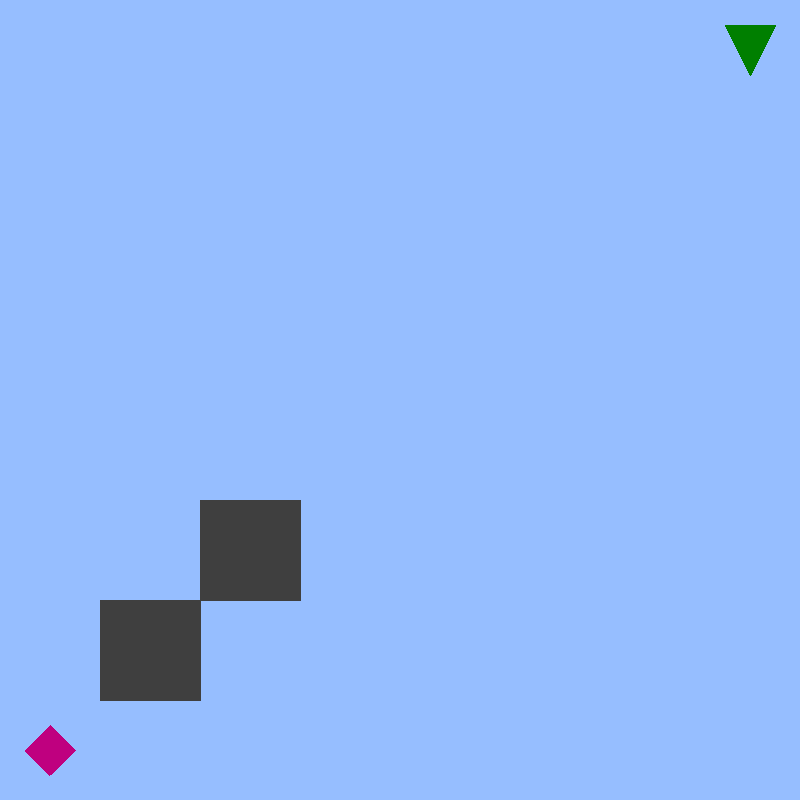

In [48]:
Image(open('gridworld_backward_induction.gif','rb').read())

# Implementation of UCBVI

The UCBVI algorithm works as follows:

* In each episode $t$, the agent has observed $n_t$ transitions $(s_i, a_i, r_i, s_{i+1})_{i=1}^{n_t}$ of states, actions, rewards and next states.
* We estimate a model of the MDP as:
$$
\mathbf{rewards:}\quad\widehat{R}_{t(s, a)} = \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i\} r_i
\\
\mathbf{transitions:}\quad \widehat{P}_t(s\prime|s, a) =  \frac{1}{N_t(s, a)} \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i, s\prime=s_{i+1}\}
$$
where
$$
N_t(s, a) = \max\left(1, \sum_{i=1}^{n_t} \mathbb{1}\{s = s_i, a = a_i\} \right)
$$
* We define an appropriate exploration bonus, which is some function of the number of visits, for example
$$
B_t(s, a) \propto \sqrt{\frac{1}{N_t(s, a)}} \cdot
$$

* Then, in episode $t$, we compute $\{Q_h^t(s, a)\}_{h=1}^H$ as the ($H$-horizon) optimal value functions in the MDP whose transitions are $\widehat{P}_t$ and whose rewards are $(\widehat{R}_t + B_t)$. At step $h$ of episode $t$, the agent chooses the action $a_h^t \in \arg\max_a Q_h^t(s, a)$.

**Complete the code below to implement UCBVI.**

In [49]:
# An example of bonus function
def bonus(N, S=None, A=None, T=None, H=None):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return np.sqrt(1.0/nn)

# The UCB-VI algorithm
def UCBVI_eps(env,H, nb_episodes,verbose="off",bonus_function=bonus,gamma=1, stop_if_done = True, use_eps = False, eps_val = 0.1):
    """
    Parameters:
        env: environement
        bonus_function : maps the number of visits to the corresponding bonus
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        episode_rewards: a vector storing the sum of rewards obtained in each episode
        states_visited: a vector storing the number of states/action pairs visited until each episode
        N_sa : array of size (S,A) giving the total number of visits in each state
        Rhat : array of size (S,A) giving the estimated average rewards
        Phat : array of size (S,A,S) giving the estimated transition probabilities
        optimistic_Q : array of size (H,S,A) giving the optimistic Q function used in the last episode
    """
    S = env.observation_space.n
    A = env.action_space.n
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sa = np.zeros((S,A), dtype=int) # number of visits

    N_sas = np.zeros((S,A,S), dtype=int) # number of transitions
    S_sa = np.zeros((S,A)) # cumulative rewards
    episode_rewards = np.zeros((nb_episodes,))
    states_visited = np.zeros((nb_episodes,))
    
    T = nb_episodes * H

    optimistic_Q = np.random.rand(H+1, S, A)

    for k in range(nb_episodes):

        sum_rewards = 0
        state, _ = env.reset()

        ### TO BE COMPLETED: RUN AN EPISODE OF UCV-VI
        optimistic_Q = backward_induction(Phat, Rhat + bonus_function(N_sa, S, A, T, H), H, gamma=1.0)
        state, _ = env.reset()
        for h in range(H):
            if use_eps:
                if np.random.rand() < eps_val:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(optimistic_Q[h, state,:])
                eps_val
            else:
                action = np.argmax(optimistic_Q[h, state,:])
            next_state, reward, done, trunc, info = env.step(action)
            N_sa[state, action] += 1
            N_sas[state, action, next_state] += 1
            S_sa[state, action] += reward
            Phat[state, action, :] = N_sas[state, action, :] / N_sa[state, action]
            Rhat[state, action] = S_sa[state, action] / N_sa[state, action]
            sum_rewards += reward

            state = next_state
            if stop_if_done and done:
                break

        episode_rewards[k] = sum_rewards
        states_visited[k] = (N_sa.sum(axis=1) > 0).sum()

        if (verbose=="on"):
          # periodically display the rewards collected and visited states
          if k % 50 == 0 or k==1:
            print("rewards in episode {}: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", states_visited[k] )
            # print(V[0, :])
    optimistic_Q = backward_induction(Phat, Rhat + bonus_function(N_sa, S, A, T, H), H, gamma=1.0)
    return episode_rewards, states_visited, N_sa, Rhat, Phat,optimistic_Q

## Question 1

**1. To check whether the algorithm is working, you can visualize the amount of rewards gathered in episodes with the default bonus, as well as the number of visited states since the beginning (which measures how well the environment is being explored). Based on your findings, how many episodes seem necessary for the algorithm to behave well?**

In [52]:
HORIZON = 200
NUM_EPISODES = 5000

env = ScaleRewardWrapper(get_discrete_mountain_car_env())
rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q = UCBVI_eps(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="on")
Q_value_empirical_MDP = backward_induction(Phat, Rhat , HORIZON, gamma=1.0)

rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0
rewards in episode 50: 1.0, Number of visited states:  78.0
rewards in episode 100: 1.0, Number of visited states:  78.0
rewards in episode 150: 1.0, Number of visited states:  79.0
rewards in episode 200: 1.0, Number of visited states:  80.0
rewards in episode 250: 1.0, Number of visited states:  80.0
rewards in episode 300: 1.0, Number of visited states:  80.0
rewards in episode 350: 1.0, Number of visited states:  80.0
rewards in episode 400: 1.0, Number of visited states:  80.0
rewards in episode 450: 1.0, Number of visited states:  80.0
rewards in episode 500: 1.0, Number of visited states:  82.0
rewards in episode 550: 1.0, Number of visited states:  82.0
rewards in episode 600: 1.0, Number of visited states:  82.0
rewards in episode 650: 1.0, Number of visited states:  82.0
rewards in episode 700: 1.0, Number of visited states:  82.0
rewards in episode 750: 1.0, Nu

Text(0.5, 1.0, 'Rewards per episode with the default bonus')

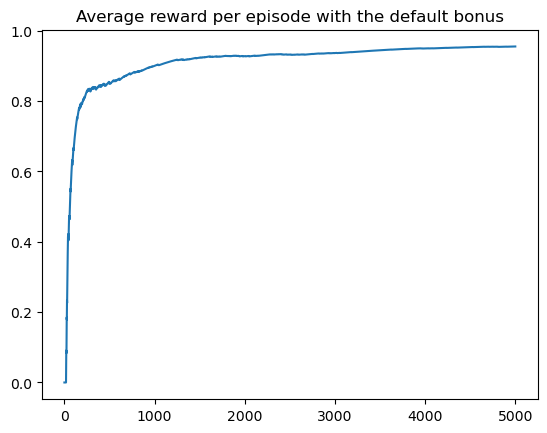

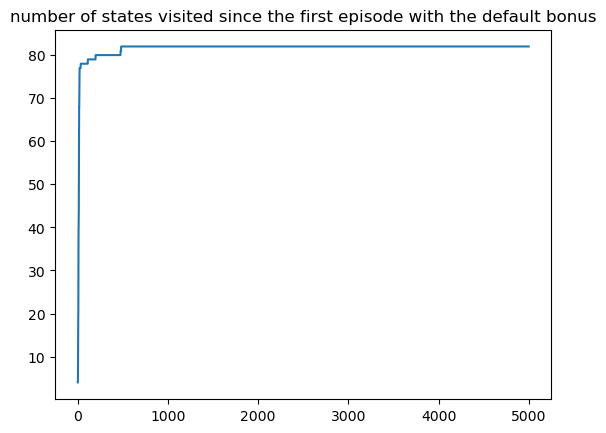

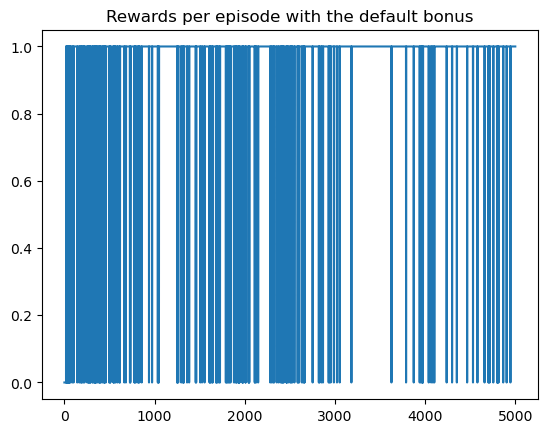

In [53]:
plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
plt.title("Average reward per episode with the default bonus")

plt.figure(2)
plt.plot(cum_visits)
plt.title("number of states visited since the first episode with the default bonus")

plt.figure(3)
plt.plot(rewards)
plt.title("Rewards per episode with the default bonus")

In [62]:
print(Q_value_empirical_MDP.shape)
print(optimistic_Q.shape)

(201, 100, 3)
(201, 100, 3)


## Question 2

**2. UCBVI's first purpose is not to output a candidate optimal policy, but if you want to do so, what is (are) reasonnable candidate(s)? You can check by looking how the agent behaves under this (these) policies, i.e. whether it solves the task. You can also display a 2D visualization of associated Q functions.**

In [55]:
policy = np.array([[np.argmax(optimistic_Q[h,s,:]) for s in range(env.observation_space.n)] for h in range(HORIZON+1)])
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)



/opt/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


In [56]:
policy = np.array([[np.argmax(Q_value_empirical_MDP[h,s,:]) for s in range(env.observation_space.n)] for h in range(HORIZON+1)])
record_video(env,"UCB-VI-optimistic", HORIZON,policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 1.0


Displaying the value of this policy is not possible, as it would require to perform policy evaluation, and as P and R are unknown, Monte-Carlo evaluation is the only option. Let's keep this for later. For now a proxy is to visualize $\max_{a} Q(s,a)$ when $\pi$ is greedy wrt to $Q$. For the optimistic policy, $Q$ is the optimistic Q function.


/opt/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.discretized_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.discretized_states` for environment variables or `env.get_wrapper_attr('discretized_states')` that will search the reminding wrappers.
  logger.warn(


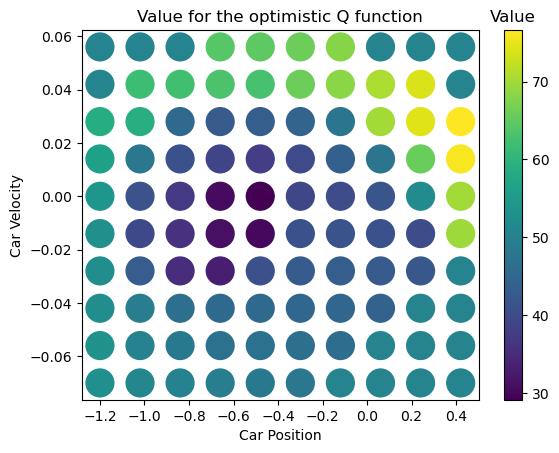

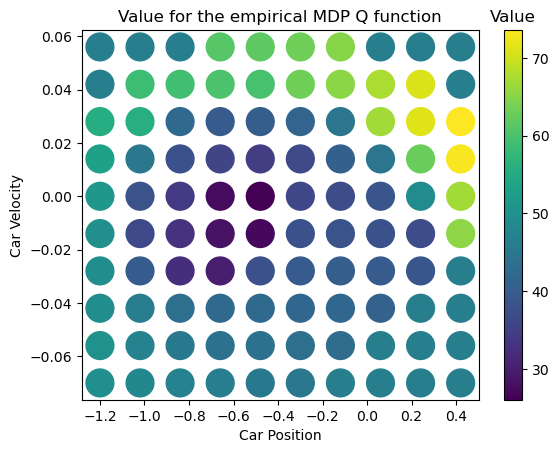

In [57]:
def show_Q_fonction(Q_function, value_method = "optimistic"):
    value = np.max(Q_function,axis=2)
    plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0, :], s=400)
    plt.xlabel('Car Position')
    plt.ylabel('Car Velocity')
    clb=plt.colorbar()
    clb.ax.set_title(f'Value')
    plt.title(f'Value for the {value_method} Q function')
    plt.show()
    
show_Q_fonction(optimistic_Q, value_method = "optimistic")
show_Q_fonction(Q_value_empirical_MDP,  value_method = "empirical MDP")

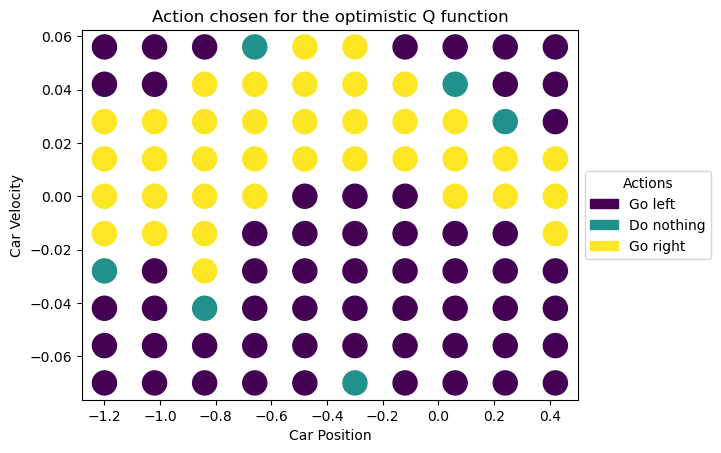

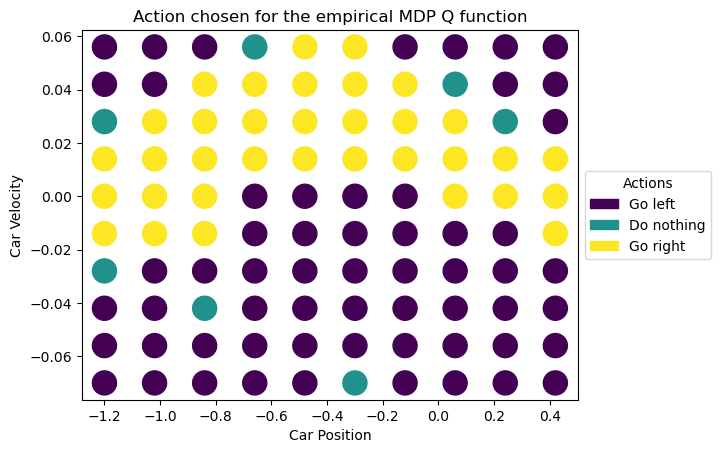

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def show_actions(Q_function, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), value_method="optimistic"):
    value = np.argmax(Q_function, axis=2)  # Assuming Q_function is 2D: states x actions

    # Assuming env.discretized_states is structured correctly for your problem.
    plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0,:], s=300, cmap='viridis')
    plt.xlabel('Car Position')
    plt.ylabel('Car Velocity')
    plt.title(f'Action chosen for the {value_method} Q function')

    # Create a custom legend
    # You might need to adjust colors to match the viridis colormap for the specific action values.
    colors = [plt.cm.viridis(i / 2) for i in range(3)]  # Adjust to match the viridis colormap
    legend_labels = ['Go left', 'Do nothing', 'Go right']
    patches = [Patch(color=colors[i], label=legend_labels[i]) for i in range(3)]
    plt.legend(handles=patches, title="Actions", loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
show_actions(optimistic_Q, env, value_method = "optimistic")
show_actions(Q_value_empirical_MDP,  env, value_method = "empirical MDP")



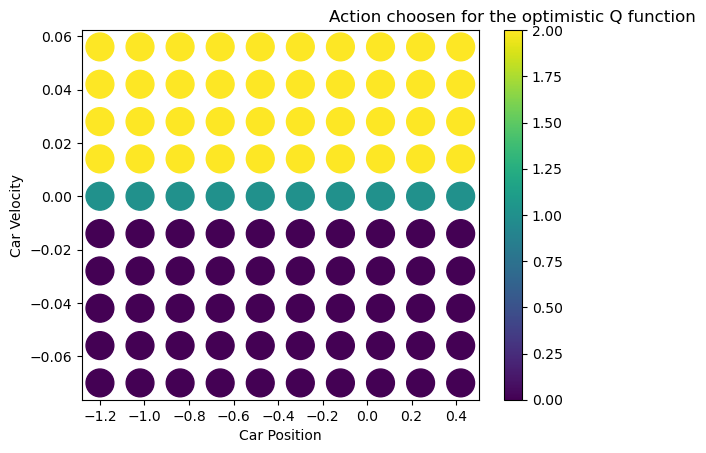

In [59]:
def old_show_actions(Q_function, value_method = "optimistic"):
    value = np.argmax(Q_function,axis=2)
    plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0, :], s=400)
    plt.xlabel('Car Position')
    plt.ylabel('Car Velocity')
    clb=plt.colorbar()
    clb.ax.set_title(f'Action choosen for the {value_method} Q function')
    plt.show()

def generate_best_theorical_bonus(env, S, A):
    """ bonus BINARY
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    bonus_opti = np.zeros((S, A))
    for s in range(S):
        p = env.discretized_states[0, s]
        v = env.discretized_states[1, s]
        margin = 0.01
        if v > margin :
            bonus_opti[s,2] = 100
        elif v > -margin:
            bonus_opti[s,1] = 100
    return bonus_opti

bon = generate_best_theorical_bonus(env, S=100, A=3)
old_show_actions([bon])

In [60]:
policy = np.array([[np.argmax(bon[s,:]) for s in range(env.observation_space.n)] for h in range(HORIZON+1)])
record_video(env, "UCB-VI-optimistic", HORIZON, policy)
Video('gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4', embed=True)

Moviepy - Building video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/sbraun/Desktop/MVA/M2/RL/DM/gym_videos/UCB-VI-optimistic/rl-video-episode-0.mp4
Reward sum: 0.0


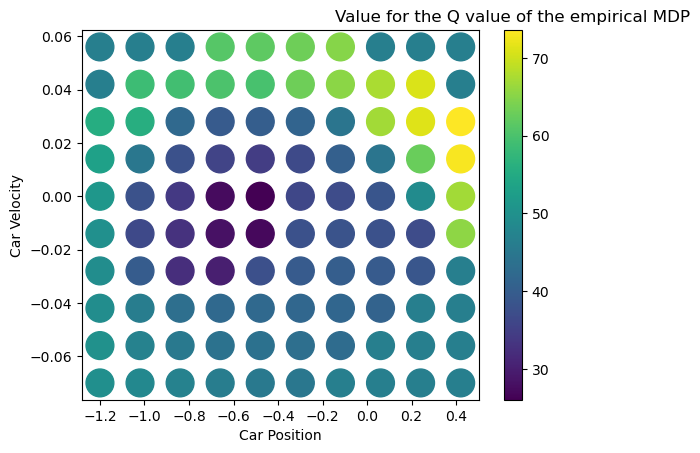

In [61]:
import matplotlib.patches as mpatches
S=env.observation_space.n
def visualise_actions(mat, ax =None):
    if ax == None:
        fig = plt.figure(figsize = (5,5))
        ax = fig.add_subplot()
    labels = ["Move Left", "Don't Accelerate", "Move Right"]
    cmap = plt.cm.get_cmap('Blues', 8) 
    value =  np.max(mat,axis=2)
    ax.pcolor(range(-int(S/2),int(S/2)), range(-int(S/2), int(S/2)), value[0, :], cmap = cmap)
    ax.set_xlabel("Position", fontsize = 15)
    ax.set_ylabel("Velocity", fontsize = 15)
    # ax.set_title("Approximate Value Function", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
    ax.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
               [labels[i] for i in range(3)])
    
Q_function = Q_value_empirical_MDP
value = np.max(Q_function,axis=2)
plt.scatter(env.discretized_states[0, :], env.discretized_states[1, :], c=value[0, :], s=400)
plt.xlabel('Car Position')
plt.ylabel('Car Velocity')
clb=plt.colorbar()
clb.ax.set_title('Value for the Q value of the empirical MDP')
plt.show()

## Question 3

In theory, any algorithm with an upper bound $\mathbb{E}[R_T] \leq B_T$ on its expected regret can be used to output an $\varepsilon$-optimal policy with high probability using the following trick: run the algorithm for a sufficiently large $T$ and output a policy $\widehat{\pi}_T$ chosen at random among the first $T$ policies used by the algorithm. The point of this question is to quantify how long.    

**3. [Theory] For a given $T$, give an upper bound on the probability $\mathbb{P}(V^\star - V^{\widehat{\pi}_T} > \varepsilon)$ that depends on $T,\varepsilon$ and $B_T$ (you can use Markov's inequality). Deduce the order of magnitude of the number of episodes needed by UCB-VI to output a $\varepsilon$-optimal policy with probability $1-\delta$. Comment on the result.**

## Question 4

**4. UCB-VI has actually some guarantees in terms of regret, so you can try to optimize the algorithm for the setting it is designed for.**

Explore different kind of bonusses for UCB-VI, in terms of resulting *expected* cumulative rewards. You may also compare bonus-based "directed" exploration to a model-based algorithm using instead $\epsilon$-greedy exploration.

In [158]:
# An example of bonus function
def count_decay_bonus(N, S=None, A=None, T=None, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=None, c=None, H=None, nn=None):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return np.sqrt(1.0/nn)

def log_count_decay_bonus(N, S=None, A=None, T=None, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=None, c=None, H=None, nn=None):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    return np.sqrt(np.log(nn)/nn)

def bonus_UCBVI_CH(N, S, A, T, H, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=1e-3, c=7.0):
    """ bonus_1 paper 
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.maximum(N, 1)
    L = np.log( 5.0 * S * A * T / delta )
    bon = c * H * L * np.sqrt(1.0/nn)
    return bon/np.max(bon)

def binary_bonus(N, S=None, A=None, T=None, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=None, c=None, H=None, nn=None):
    """ bonus BINARY
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.minimum(N, 1)
    return 1.0 - nn

def normalize_binary_bonus(N, S, A, T, H, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=1e-3, c=7.0):
    """ bonus BINARY
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    nn = np.minimum(N, 1)
    number_of_states_visited = (N.sum(axis=1) > 0).sum()
    number_of_states_visited = np.minimum(number_of_states_visited, 1)
    return (1.0 - nn) / number_of_states_visited

def uniform_bonus(N, S=None, A=None, T=None, H=None, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=1e-3, c=1.0):
    """ bonus BINARY
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    return c*np.ones_like(N) 

def zero_bonus(N, S=None, A=None, T=None, H=None, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=1e-3, c=7.0):
    """ bonus BINARY
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    return np.zeros_like(N) 

def generate_best_theorical_bonus(N, S=None, A=None, T=None, H=None, env = ScaleRewardWrapper(get_discrete_mountain_car_env()), delta=1e-3, c=7.0):
    """ bonus BINARY
    input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    bonus_opti = np.zeros((S, A))
    for s in range(S):
        p = env.discretized_states[0, s]
        v = env.discretized_states[1, s]
        margin = 0.01
        if v > margin :
            bonus_opti[s,2] = 1000
        elif v > -margin:
            bonus_opti[s,1] = 1000
        else:
            bonus_opti[s,0] = 1000
    return bonus_opti


In [151]:
# The UCB-VI algorithm
def UCBVI(env,H, nb_episodes,verbose="off",bonus_function=bonus,gamma=1, stop_if_done = False):
    """
    Parameters:
        env: environement
        bonus_function : maps the number of visits to the corresponding bonus
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        episode_rewards: a vector storing the sum of rewards obtained in each episode
        states_visited: a vector storing the number of states/action pairs visited until each episode
        N_sa : array of size (S,A) giving the total number of visits in each state
        Rhat : array of size (S,A) giving the estimated average rewards
        Phat : array of size (S,A,S) giving the estimated transition probabilities
        optimistic_Q : array of size (H,S,A) giving the optimistic Q function used in the last episode
    """
    S = env.observation_space.n
    A = env.action_space.n
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sa = np.zeros((S,A), dtype=int) # number of visits

    N_sas = np.zeros((S,A,S), dtype=int) # number of transitions
    S_sa = np.zeros((S,A)) # cumulative rewards
    episode_rewards = np.zeros((nb_episodes,))
    states_visited = np.zeros((nb_episodes,))
    
    T = nb_episodes * H

    optimistic_Q = np.random.rand(H+1, S, A)

    for k in range(nb_episodes):

        sum_rewards = 0
        state, _ = env.reset()

        ### TO BE COMPLETED: RUN AN EPISODE OF UCV-VI
        
        bon = bonus_function(N_sa, S, A, T, H)
        optimistic_Q = backward_induction(Phat, Rhat + bon, H, gamma=1.0)
        state, _ = env.reset()
        for h in range(H):
            action = np.argmax(optimistic_Q[h, state,:])
            next_state, reward, done, trunc, info = env.step(action)
            N_sa[state, action] += 1
            N_sas[state, action, next_state] += 1
            S_sa[state, action] += reward
            Phat[state, action, :] = N_sas[state, action, :] / N_sa[state, action]
            Rhat[state, action] = S_sa[state, action] / N_sa[state, action]
            sum_rewards += reward

            state = next_state
            if stop_if_done and done:
                break
        # show_Q_fonction(optimistic_Q)

        episode_rewards[k] = sum_rewards
        states_visited[k] = (N_sa.sum(axis=1) > 0).sum()

        if (verbose=="on"):
          # periodically display the rewards collected and visited states
          if k % 50 == 0 or k==1:
            print("rewards in episode {}: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", states_visited[k] )
            show_Q_fonction(optimistic_Q)
            show_actions(optimistic_Q)
            # print(V[0, :])
    bon = bonus_function(N_sa, S, A, T, H)
    optimistic_Q = backward_induction(Phat, Rhat + bon, H, gamma=1.0)
    return episode_rewards, states_visited, N_sa, Rhat, Phat,optimistic_Q

/opt/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.discretized_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.discretized_states` for environment variables or `env.get_wrapper_attr('discretized_states')` that will search the reminding wrappers.
  logger.warn(


Text(0.5, 1.0, 'Average reward per episode after 1 independant run of the algorithm')

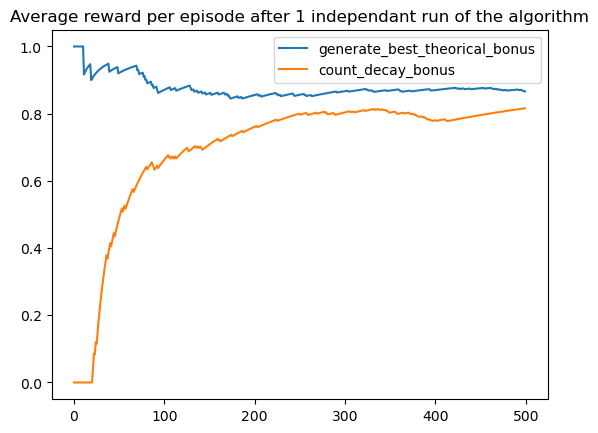

In [58]:
HORIZON = 200
NUM_EPISODES = 500
NUMBER_OF_RUN = 10

env = ScaleRewardWrapper(get_discrete_mountain_car_env())

# for bonus_function in [bonus_1_original_paper, count_decay_bonus, binary_bonus, uniform_bonus]:
for bonus_function in [generate_best_theorical_bonus, count_decay_bonus, bonus_UCBVI_CH, binary_bonus, normalize_binary_bonus, uniform_bonus,zero_bonus]:
    mean_rewards = None
    for run in range(NUMBER_OF_RUN):
        rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q = UCBVI(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="off", bonus_function=bonus_function, stop_if_done=True)
        if mean_rewards is None:
            mean_rewards = rewards
        else:
            mean_rewards = rewards / run + mean_rewards * (run-1) / run
    plt.plot([np.cumsum(mean_rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)], label=bonus_function.__name__)

plt.legend()
plt.title(f"Average reward per episode after {NUMBER_OF_RUN} independant run of the algorithm")
# plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
# plt.plot(rewards)

# plt.figure(2)
# plt.plot(cum_visits)
# plt.title("number of states visited since the first episode")


In [152]:
# An example of bonus function
def bonus_paper_2(N, S=None, A=None, T=None, H=None, N_prim=None, V=None, P=None, delta = 1e-2):
    """input : a numpy array (nb of visits)
    output : a numpy array (bonuses)"""
    
    L = np.log(5 * S* A * T / delta)
    
    bonus_val = np.zeros((S, A))

    nn = np.maximum(N, 1)
    nn_prim = np.maximum(N_prim, 1)

    for s in range(S):
        for a in range(A):
            temp_var = []
            for s_ in range(S):
                c = V[(h+1,s_)] * P[(s,a,s_)]
                temp_var.append(c)
            var = np.var(temp_var)
            term1 = np.sqrt(8.*L*var/nn[s,a])
            term2 = 14.*H*L/(3.*nn[s,a])
            sum_y = 0
            for y in range(S):
                sum_y += P[s,a,y] * min( 100**2*H**3*S**2*A*L**2 / nn_prim[h, s, a] )
            term3 = np.sqrt( (8*sum_y) /nn[s,a] )
            term3 = term2 * 0.0
            bonus_val[s,a] += term1 + term2 + term3
        
    return bonus_val / np.max(bonus_val)

def backward_induction_prim(P, R, H, gamma=1.0):
    """
    Parameters:
        P: transition function (S,A,S)-dim matrix
        R: reward function (S,A)-dim matrix
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        The optimal Q-function: array of shape (horizon, S,A)
    """
    S, A = P.shape[0], P.shape[1]
    V = np.zeros((H + 1, S))
    Q = np.zeros((H+1,S,A))
    for h in range(H-1, -1, -1):
        for s in range(S):
            # compute the value
            for a in range(A):
              Q[h, s, a] = R[s, a] + gamma * np.sum(P[s, a, :] * V[h+1, :])
            V[h,s] = np.max(Q[h,s,:])
            # ... and clip it (needed later in UCB-VI)
            if (V[h, s] > H - h):
                V[h, s] = H - h
    return Q, V

# The UCB-VI algorithm
def UCBVI_prim(env,H, nb_episodes,verbose="off",bonus_function=bonus_paper_2,gamma=1, stop_if_done = False):
    """
    Parameters:
        env: environement
        bonus_function : maps the number of visits to the corresponding bonus
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        episode_rewards: a vector storing the sum of rewards obtained in each episode
        states_visited: a vector storing the number of states/action pairs visited until each episode
        N_sa : array of size (S,A) giving the total number of visits in each state
        Rhat : array of size (S,A) giving the estimated average rewards
        Phat : array of size (S,A,S) giving the estimated transition probabilities
        optimistic_Q : array of size (H,S,A) giving the optimistic Q function used in the last episode
    """
    S = env.observation_space.n
    A = env.action_space.n
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sa = np.zeros((S,A), dtype=int) # number of visits

    N_sas = np.zeros((S,A,S), dtype=int) # number of transitions
    N_prim = np.zeros((H,S,A,S), dtype=int)
    S_sa = np.zeros((S,A)) # cumulative rewards
    episode_rewards = np.zeros((nb_episodes,))
    states_visited = np.zeros((nb_episodes,))
    
    T = nb_episodes * H

    optimistic_Q, V = backward_induction_prim(Phat, Rhat + bonus_function(N_sa, S, A, T, H, N_prim, np.ones((H+1, S)), Phat), H, gamma=1.0)

    for k in range(nb_episodes):

        sum_rewards = 0
        state, _ = env.reset()

        ### TO BE COMPLETED: RUN AN EPISODE OF UCV-VI
        state, _ = env.reset()
        for h in range(H):
            action = np.argmax(optimistic_Q[h, state,:])
            next_state, reward, done, trunc, info = env.step(action)
            N_sa[state, action] += 1
            N_sas[state, action, next_state] += 1
            S_sa[state, action] += reward
            Phat[state, action, :] = N_sas[state, action, :] / N_sa[state, action]
            Rhat[state, action] = S_sa[state, action] / N_sa[state, action]
            sum_rewards += reward

            state = next_state
            if stop_if_done and done:
                break

        episode_rewards[k] = sum_rewards
        states_visited[k] = (N_sa.sum(axis=1) > 0).sum()

        if (verbose=="on"):
          # periodically display the rewards collected and visited states
          if k % 50 == 0 or k==1:
            print("rewards in episode {}: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", states_visited[k] )
            # print(V[0, :])
            
        optimistic_Q, V = backward_induction_prim(Phat, Rhat + bonus_function(N_sa, S, A, T, H, N_prim, V, Phat), H, gamma=1.0)

    return episode_rewards, states_visited, N_sa, Rhat, Phat,optimistic_Q

In [153]:
HORIZON = 200
NUM_EPISODES = 500

env = ScaleRewardWrapper(get_discrete_mountain_car_env())

rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q = UCBVI_prim(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="on")
Q_value_empirical_MDP = backward_induction(Phat, Rhat , HORIZON, gamma=1.0)


plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
plt.title("Average reward per episode with the default bonus")



rewards in episode 0: 0.0, Number of visited states:  4.0
rewards in episode 1: 0.0, Number of visited states:  4.0


KeyboardInterrupt: 

/opt/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.discretized_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.discretized_states` for environment variables or `env.get_wrapper_attr('discretized_states')` that will search the reminding wrappers.
  logger.warn(


Text(0.5, 1.0, 'Average reward per episode after 10 independant run of the algorithm')

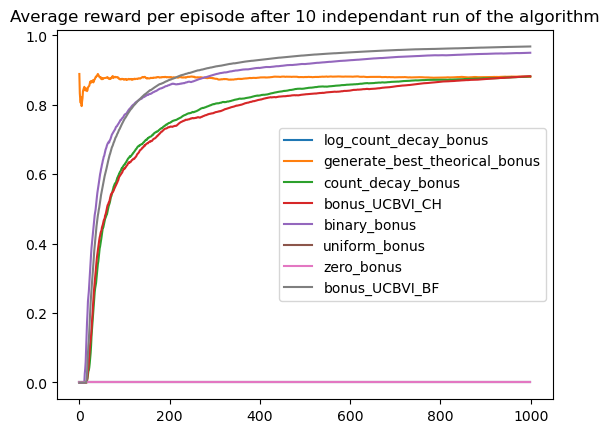

In [159]:
HORIZON = 200
NUM_EPISODES = 1000
NUMBER_OF_RUN = 10

env = ScaleRewardWrapper(get_discrete_mountain_car_env())

# for bonus_function in [bonus_1_original_paper, count_decay_bonus, binary_bonus, uniform_bonus]:
for bonus_function in [log_count_decay_bonus, generate_best_theorical_bonus, count_decay_bonus, bonus_UCBVI_CH, binary_bonus, uniform_bonus,zero_bonus]:
    mean_rewards = None
    for run in range(NUMBER_OF_RUN):
        rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q = UCBVI(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="off", bonus_function=bonus_function, stop_if_done=True)
        if mean_rewards is None:
            mean_rewards = rewards
        else:
            mean_rewards = rewards / run + mean_rewards * (run-1) / run
    plt.plot([np.cumsum(mean_rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)], label=bonus_function.__name__)

mean_rewards = None
for run in range(NUMBER_OF_RUN):
    rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q = UCBVI_prim(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="off", stop_if_done=True)
    if mean_rewards is None:
        mean_rewards = rewards
    else:
        mean_rewards = rewards / run + mean_rewards * (run-1) / run
plt.plot([np.cumsum(mean_rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)], label="bonus_UCBVI_BF")


plt.legend()
plt.title(f"Average reward per episode after {NUMBER_OF_RUN} independant run of the algorithm")
# plt.plot([np.cumsum(rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)])
# plt.plot(rewards)

# plt.figure(2)
# plt.plot(cum_visits)
# plt.title("number of states visited since the first episode")


## Greedy

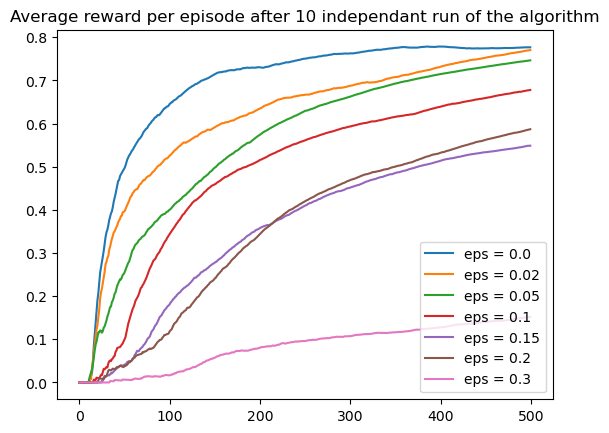

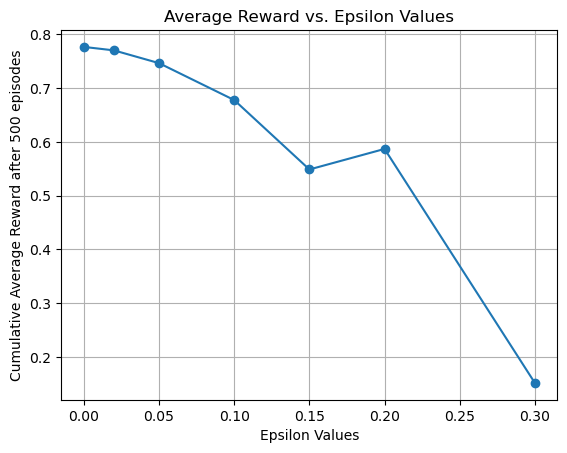

In [42]:
HORIZON = 200
NUM_EPISODES = 500
NUMBER_OF_RUN = 10

env = ScaleRewardWrapper(get_discrete_mountain_car_env())

eps_vals = [0.0, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]
associated_average_rew = []

for eps_val in eps_vals:
    for bonus_function in [binary_bonus]:
        mean_rewards = None
        for run in range(NUMBER_OF_RUN):
            rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q = UCBVI_eps(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="off", bonus_function=bonus_function, use_eps = True , eps_val = eps_val)
            if mean_rewards is None:
                mean_rewards = rewards
            else:
                mean_rewards = rewards / run + mean_rewards * (run-1) / run
        cum_sum = [np.cumsum(mean_rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)]
        plt.plot(cum_sum, label=f"eps = {eps_val}")
        associated_average_rew.append(cum_sum[-1])

plt.legend()
plt.title(f"Average reward per episode after {NUMBER_OF_RUN} independant run of the algorithm")

plt.figure(2)
plt.plot(eps_vals, associated_average_rew, marker='o')  # 'marker' is optional, enhances visibility of data points

# Adding title and labels
plt.title('Average Reward vs. Epsilon Values')
plt.xlabel('Epsilon Values')
plt.ylabel(f'Cumulative Average Reward after {NUM_EPISODES} episodes')

# Optional: Adding a grid for better readability
plt.grid(True)

# Display the plot
plt.show()


In [177]:
def UCBVI_eps_decay(env,H, nb_episodes,verbose="off",bonus_function=bonus,gamma=1, stop_if_done = True, use_eps = True, eps_min = 0.01, eps_decay = 2_000, delay_decay = 500):
    """
    Parameters:
        env: environement
        bonus_function : maps the number of visits to the corresponding bonus
        H: horizon
        gamma: discount factor. Usually set to 1.0 in finite-horizon problems

    Returns:
        episode_rewards: a vector storing the sum of rewards obtained in each episode
        states_visited: a vector storing the number of states/action pairs visited until each episode
        N_sa : array of size (S,A) giving the total number of visits in each state
        Rhat : array of size (S,A) giving the estimated average rewards
        Phat : array of size (S,A,S) giving the estimated transition probabilities
        optimistic_Q : array of size (H,S,A) giving the optimistic Q function used in the last episode
    """
    S = env.observation_space.n
    A = env.action_space.n
    Phat = np.ones((S,A,S)) / S
    Rhat = np.zeros((S,A))
    N_sa = np.zeros((S,A), dtype=int) # number of visits
    eps_decay *= H
    delay_decay *= H

    N_sas = np.zeros((S,A,S), dtype=int) # number of transitions
    S_sa = np.zeros((S,A)) # cumulative rewards
    episode_rewards = np.zeros((nb_episodes,))
    states_visited = np.zeros((nb_episodes,))
    
    T = nb_episodes * H

    optimistic_Q = np.random.rand(H+1, S, A)

    t = 0
    eps_val = 1.
    tab_eps = [] 

    for k in range(nb_episodes):
        tab_eps.append(eps_val)
        sum_rewards = 0
        state, _ = env.reset()

        ### TO BE COMPLETED: RUN AN EPISODE OF UCV-VI
        optimistic_Q = backward_induction(Phat, Rhat + bonus_function(N_sa, S, A, T, H), H, gamma=1.0)
        state, _ = env.reset()
        for h in range(H):
            t+=1
            if use_eps:
                if t > delay_decay:
                    eps_val = ( 1 - min((t-delay_decay)/eps_decay,1) ) * (1-eps_min)
                if np.random.rand() < eps_val:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(optimistic_Q[h, state,:])
                eps_val
            else:
                action = np.argmax(optimistic_Q[h, state,:])
            next_state, reward, done, trunc, info = env.step(action)
            N_sa[state, action] += 1
            N_sas[state, action, next_state] += 1
            S_sa[state, action] += reward
            Phat[state, action, :] = N_sas[state, action, :] / N_sa[state, action]
            Rhat[state, action] = S_sa[state, action] / N_sa[state, action]
            sum_rewards += reward

            state = next_state
            if stop_if_done and done:
                break

        episode_rewards[k] = sum_rewards
        states_visited[k] = (N_sa.sum(axis=1) > 0).sum()

        if (verbose=="on"):
          # periodically display the rewards collected and visited states
          if k % 50 == 0 or k==1:
            print("rewards in episode {}: {}".format(k, episode_rewards[k]), end = ", ")
            print("Number of visited states: ", states_visited[k] )
            print(eps_val)
            # print(V[0, :])
    optimistic_Q = backward_induction(Phat, Rhat + bonus_function(N_sa, S, A, T, H), H, gamma=1.0)
    return episode_rewards, states_visited, N_sa, Rhat, Phat,optimistic_Q, tab_eps

rewards in episode 0: 0.0, Number of visited states:  4.0
1.0
rewards in episode 1: 0.0, Number of visited states:  4.0
1.0
rewards in episode 50: 0.0, Number of visited states:  14.0
1.0
rewards in episode 100: 0.0, Number of visited states:  18.0
1.0
rewards in episode 150: 0.0, Number of visited states:  20.0
1.0
rewards in episode 200: 0.0, Number of visited states:  20.0
1.0
rewards in episode 250: 0.0, Number of visited states:  20.0
1.0
rewards in episode 300: 0.0, Number of visited states:  20.0
1.0
rewards in episode 350: 0.0, Number of visited states:  21.0
1.0
rewards in episode 400: 0.0, Number of visited states:  21.0
1.0
rewards in episode 450: 0.0, Number of visited states:  24.0
1.0
rewards in episode 500: 0.0, Number of visited states:  24.0
0.9895050000000001
rewards in episode 550: 0.0, Number of visited states:  24.0
0.964755
rewards in episode 600: 0.0, Number of visited states:  24.0
0.940005
rewards in episode 650: 0.0, Number of visited states:  24.0
0.915254999

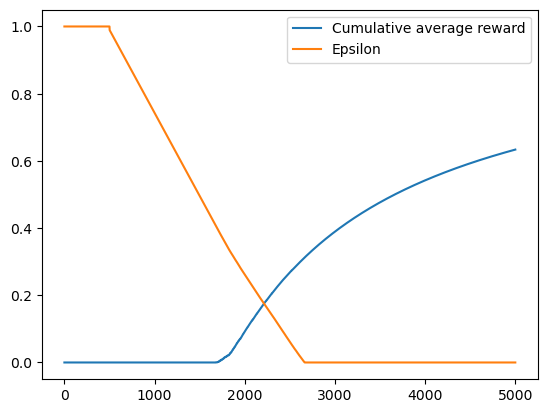

In [178]:
NUM_EPISODES = 5_000

for bonus_function in [binary_bonus]:
    
    rewards, cum_visits,N_sa, Rhat, Phat, optimistic_Q, eps = UCBVI_eps_decay(env, H=HORIZON, nb_episodes=NUM_EPISODES,verbose="on", bonus_function=bonus_function, use_eps = True)
    mean_rewards = rewards
    cum_sum = [np.cumsum(mean_rewards)[episode]/(episode+1) for episode in range(NUM_EPISODES)]
    plt.plot(cum_sum, label=f"Cumulative average reward")
    plt.plot(np.array(eps), label=f"Epsilon")
    plt.legend()
    associated_average_rew.append(cum_sum[-1])

Text(0.5, 1.0, 'Cumulative average reward of the UCBVI algorithm with a greedy exploration')

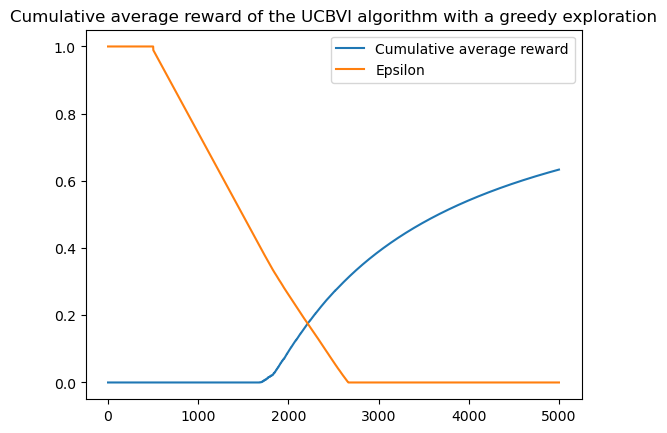

In [179]:
plt.plot(cum_sum, label=f"Cumulative average reward")
plt.plot(np.array(eps), label=f"Epsilon")
plt.legend()
plt.title("Cumulative average reward of the UCBVI algorithm with a greedy exploration")

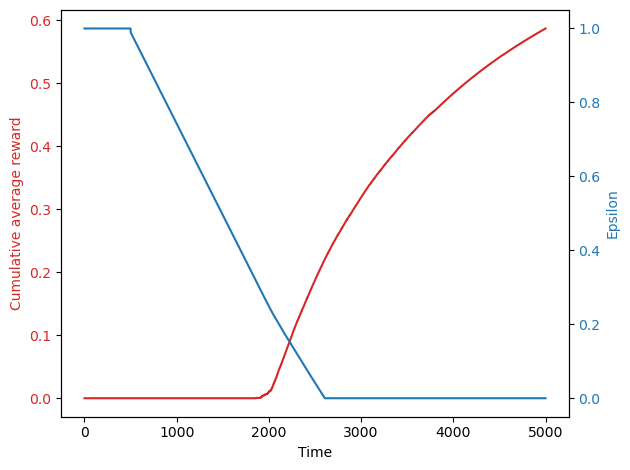

In [84]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative average reward', color=color)
ax1.plot(cum_sum, color=color, label="Cumulative average reward")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Epsilon', color=color)  
ax2.plot(np.array(eps), color=color, label="Epsilon")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

## Question 5

**5. [Theory] Our goal was to find a policy that manages to get the car up the hill. We chose to model this as solving an episodic MDP with a large enough horizon $H$. Could this task also be modelled as solving a discounted MDP? What value would you choose for the discount?**

## Question 6

**6. Compare the best model-based algorithm found in question 4. to a model-free alternative (still in terms of cumulative rewards).**

The idea is to try to make some variant of the (discounted) Q-Learning algorithm work for this problem. Learning will however still proceed in episodes of length H, with a reset, and we will similarly monitor the (undiscounted) amount of rewards gathered in each episode, for comparison with UCBVI.

You may explore one of the following possibilities: combining $\varepsilon$-greedy exploration with a careful initialization of the Q-values, or adding some exploration bonuses to the rewards.

Careful describe the chosen algorithm as well as the results.


In [100]:
import numpy as np

def epsilon_greedy(env, Q, s, epsilon):
    a = np.argmax(Q[s,:])
    if(np.random.rand()<=epsilon): # random action
        aa = np.random.randint(env.action_space.n-1)
        if aa==a:
            a=env.action_space.n-1
        else:
            a=aa
    return a

In [103]:
import gymnasium as gym

def value_iteration(env, V0, epsilon, max_iter):
    gamma = 0.9
    V = np.copy(V0)
    W = np.copy(V)
    residuals = np.zeros((max_iter))
    for i in range(max_iter):
        for s in range(env.observation_space.n):
            Q = np.zeros((env.action_space.n))
            for a in range(env.action_space.n):
                outcomes = env.unwrapped.P[s][a]
                for o in outcomes:
                    p  = o[0]
                    s2 = o[1]
                    r  = o[2]
                    Q[a] += p*(r+gamma*V[s2])
            W[s] = np.max(Q)
            #print(W[s])
        residuals[i] = np.max(np.abs(W-V))
        #print("abs", np.abs(W-V))
        np.copyto(V,W)
        if residuals[i]<epsilon:
            residuals = residuals[:i+1]
            break
    return V, residuals

def Q_from_V(env,V):
    gamma = 0.9
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    for s in range(env.observation_space.n):
        for a in range(env.action_space.n):
            outcomes = env.unwrapped.P[s][a]
            for o in outcomes:
                p  = o[0]
                s2 = o[1]
                r  = o[2]
                Q[s,a] += p*(r+gamma*V[s2])
    return Q

env = gym.make('FrozenLake-v1', render_mode="ansi")


In [187]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

env = ScaleRewardWrapper(get_discrete_mountain_car_env())

def Q_Learning(env, H=500, delta = 1e-3, gamma = 0.99, verbose = False, eps_min = 0.01, eps_decay = 2_000, delay_decay = 500, use_bonus = True):
    S = env.observation_space.n
    A = env.action_space.n
    N_sa = np.zeros((S,A))
    Vinit = np.zeros((env.observation_space.n))
    episode_rewards = []
    h = 0
    ep = 0
    Qql = np.zeros((env.observation_space.n,env.action_space.n)) 
    # Qql[:,2] += 1.
    count = np.zeros((env.observation_space.n,env.action_space.n)) # to track update frequencies
    max_steps = int(2e6)
    eps_val = 1
    delay_decay *= H
    eps_decay *= H
    alpha = 0.01
    error = np.zeros((max_steps))
    tab_eps = []
    x,_ = env.reset()
    ep_r = 0
    states_visited_tab = []
    for t in tqdm(range(max_steps)):
        h += 1
        if t > delay_decay:
            eps_val = ( 1 - min((t-delay_decay)/eps_decay,1) ) * (1-eps_min)
            # print(t, eps_val)
        a = epsilon_greedy(env,Qql,x,eps_val)
        y,r,d,_,_ = env.step(a)
        
        N_sa[x,a] += 1
        i_k = np.log(S*A*(N_sa[x,a] + 1)*(N_sa[x,a]+2)/delta)
        bonus = 4*1.41/(1-gamma) * np.sqrt(H*i_k / N_sa[x,a])
        if use_bonus:
            bonus = np.sqrt(np.log(N_sa[x,a])/N_sa[x,a])
        else:
            bonus = 0.
        alpha = (H+1)/(H+N_sa[x,a]) 
        # print(bonus)
        Qql[x][a] = Qql[x][a] + alpha * (r + bonus +gamma*np.max(Qql[y][:])-Qql[x][a])
        count[x][a] += 1
        error[t] = np.max(np.abs(Qql))
        ep_r += r
        if d==True or h>H:
            ep += 1
            tab_eps.append(eps_val)
            states_visited = (N_sa.sum(axis=1) > 0).sum()
            states_visited_tab.append(states_visited)
            episode_rewards.append(ep_r)
            ep_r = 0
            x,_ = env.reset()
            h = 0
            if verbose:
                # periodically display the rewards collected and visited states
                if ep % 200 == 0 or ep==1:
                    print("rewards in episode {}: {}".format(ep, episode_rewards[-1]), end = ", ")
                    
                    print("Number of visited states: ", states_visited )
                    print("eps = ", eps_val)
        else:
            x=y
        
    return episode_rewards, tab_eps, Qql, states_visited_tab

In [188]:
# episode_rewards, tab_eps, Qql, state_visited = Q_Learning(env)
episode_rewards_no_bonus, tab_eps_no_bonus, Qql_no_bonus, state_visited_no_bonus = Q_Learning(env, use_bonus=False, verbose=True)

  1%|          | 11403/2000000 [00:00<00:51, 38256.39it/s]

rewards in episode 1: 0.0, Number of visited states:  12
eps =  1


  6%|▌         | 111519/2000000 [00:02<00:48, 38755.01it/s]

rewards in episode 200: 0.0, Number of visited states:  26
eps =  1


 10%|█         | 206361/2000000 [00:05<00:45, 39237.07it/s]

rewards in episode 400: 0.0, Number of visited states:  26
eps =  1


 15%|█▌        | 308511/2000000 [00:07<00:43, 38676.43it/s]

rewards in episode 600: 0.0, Number of visited states:  32
eps =  0.93990699


 20%|██        | 406716/2000000 [00:10<00:40, 39616.57it/s]

rewards in episode 800: 0.0, Number of visited states:  32
eps =  0.84070899


 25%|██▌       | 507162/2000000 [00:12<00:37, 39500.65it/s]

rewards in episode 1000: 0.0, Number of visited states:  32
eps =  0.74151099


 31%|███       | 611552/2000000 [00:15<00:35, 39282.94it/s]

rewards in episode 1200: 0.0, Number of visited states:  36
eps =  0.64231299


 36%|███▌      | 710569/2000000 [00:17<00:32, 39590.55it/s]

rewards in episode 1400: 0.0, Number of visited states:  43
eps =  0.54311499


 40%|████      | 806260/2000000 [00:20<00:30, 39521.54it/s]

rewards in episode 1600: 0.0, Number of visited states:  46
eps =  0.44391699000000007


 45%|████▌     | 907962/2000000 [00:22<00:25, 42191.65it/s]

rewards in episode 1800: 0.0, Number of visited states:  46
eps =  0.34471899


 51%|█████     | 1012626/2000000 [00:25<00:24, 39939.06it/s]

rewards in episode 2000: 0.0, Number of visited states:  48
eps =  0.24552099000000002


 55%|█████▌    | 1107149/2000000 [00:27<00:21, 40846.54it/s]

rewards in episode 2200: 0.0, Number of visited states:  48
eps =  0.14632298999999996


 61%|██████    | 1212963/2000000 [00:30<00:19, 40450.97it/s]

rewards in episode 2400: 0.0, Number of visited states:  48
eps =  0.047124990000000005


 66%|██████▌   | 1312919/2000000 [00:32<00:16, 40677.98it/s]

rewards in episode 2600: 0.0, Number of visited states:  48
eps =  0.0


 71%|███████   | 1411041/2000000 [00:35<00:14, 40367.35it/s]

rewards in episode 2800: 0.0, Number of visited states:  48
eps =  0.0


 76%|███████▌  | 1510574/2000000 [00:37<00:11, 40987.98it/s]

rewards in episode 3000: 0.0, Number of visited states:  48
eps =  0.0


 81%|████████  | 1612902/2000000 [00:40<00:09, 40989.13it/s]

rewards in episode 3200: 0.0, Number of visited states:  48
eps =  0.0


 86%|████████▌ | 1710082/2000000 [00:42<00:07, 40178.74it/s]

rewards in episode 3400: 0.0, Number of visited states:  48
eps =  0.0


 91%|█████████ | 1811827/2000000 [00:45<00:04, 40386.39it/s]

rewards in episode 3600: 0.0, Number of visited states:  48
eps =  0.0


 95%|█████████▌| 1908986/2000000 [00:47<00:02, 40166.54it/s]

rewards in episode 3800: 0.0, Number of visited states:  48
eps =  0.0


100%|██████████| 2000000/2000000 [00:49<00:00, 40136.92it/s]


Text(0.5, 1.0, 'number of states visited since the first episode')

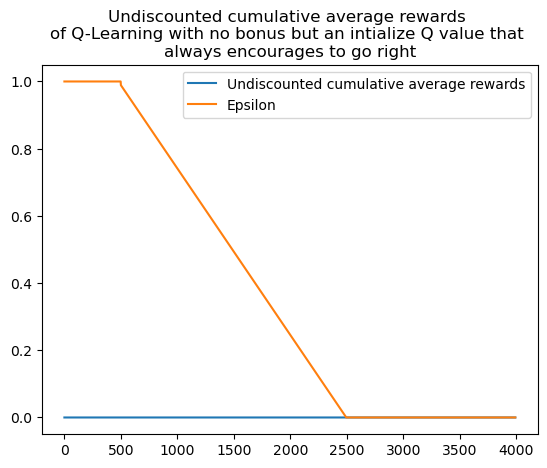

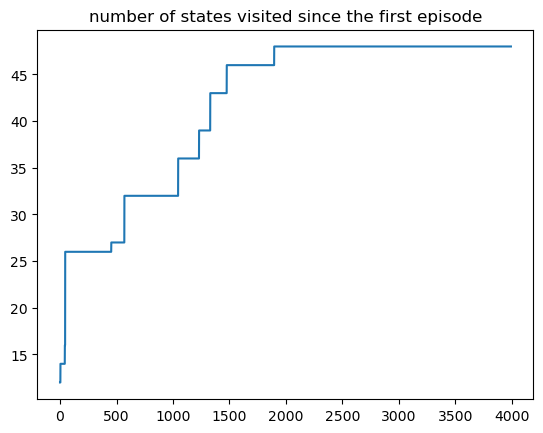

In [189]:
cum_sum = [np.cumsum(episode_rewards_no_bonus)[episode]/(episode+1) for episode in range(len(episode_rewards_no_bonus))]
plt.plot(cum_sum, label=f"Undiscounted cumulative average rewards")
plt.plot(np.array(tab_eps_no_bonus), label=f"Epsilon")
plt.legend()
plt.title('Undiscounted cumulative average rewards \nof Q-Learning with no bonus but an intialize Q value that \nalways encourages to go right')

plt.figure(2)
plt.plot(state_visited_no_bonus)
plt.title("number of states visited since the first episode")


Text(0.5, 1.0, 'number of states visited since the first episode')

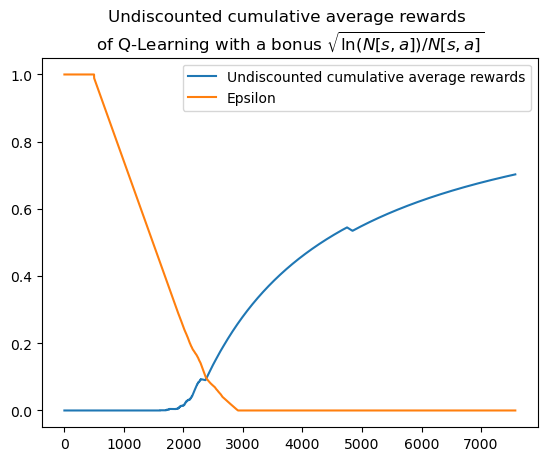

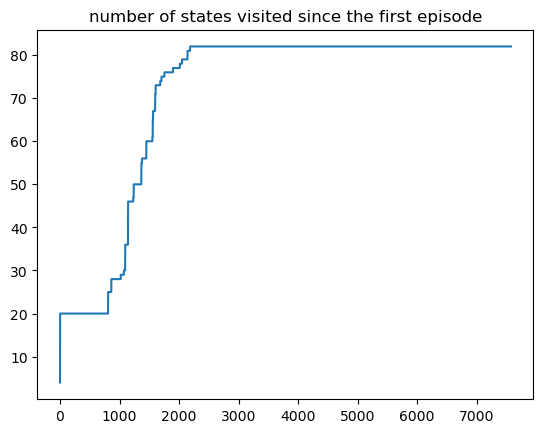

In [164]:


cum_sum = [np.cumsum(episode_rewards)[episode]/(episode+1) for episode in range(len(episode_rewards))]
plt.plot(cum_sum, label=f"Undiscounted cumulative average rewards")
plt.plot(np.array(tab_eps), label=f"Epsilon")
plt.legend()
plt.title('Undiscounted cumulative average rewards \nof Q-Learning with a bonus $\sqrt{\ln(N[s,a])/N[s,a]}$')

plt.figure(2)
plt.plot(state_visited)
plt.title("number of states visited since the first episode")

Text(0.5, 1.0, 'number of states visited since the first episode')

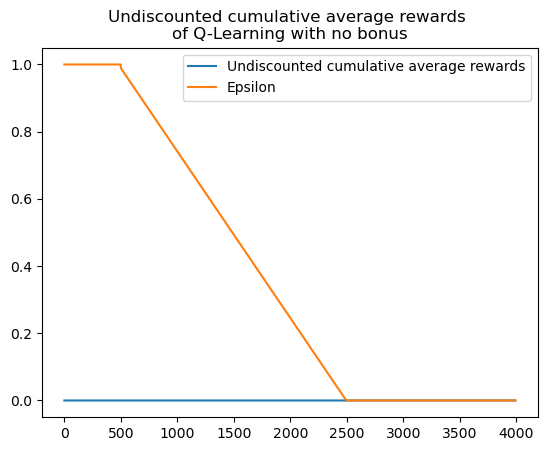

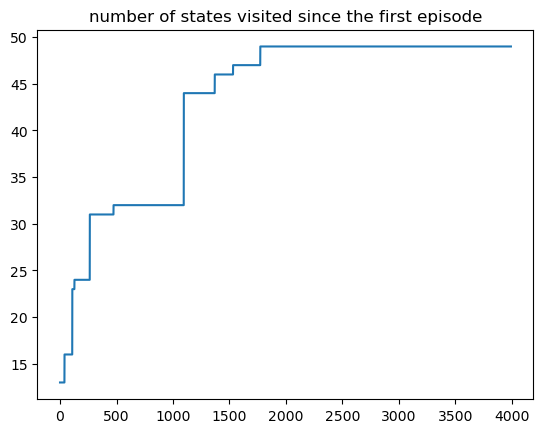

### UCRL

## Question 7

**7. [Theory] We would now like to compare the sample complexity of the model-free algorithm to that of the model-based algorithm. How would you proceed to do that?**


(you are not required to actually do it, just specify how you would proceed given the time)